In [1]:
import sys 
sys.path.append('../src') 
import numpy as np
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
import matplotlib.pyplot as plt
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import calc_energy, torch2np, np2torch, get_data
import glob
import os
import time
# from importlib import reload


import KPCA
from KPCA import compute_kernel_matrix

from sklearn.decomposition import KernelPCA
import optuna


device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)


def kernel(X:torch.Tensor, Y, theta, dx = 0.0125, dy = None):
    """
    Compute the total energy of a visco-elastic flow

    Parameters
    ----------
    X : array_like
        Simulation data
    Wi, beta, Re : float
                    Simulation paramters
    dx : float
        uniform mesh spacing

    Returns
    -------
    elastic : array
            The elastic energy on each snapshot of the input
    kinetic : array
            The kinect energy on each snapshot of the input
    total_energy: array
            The total energy on each snapshot of the input
    """
    if dy is None:
        dy = dx
    area = dx*dy * 0.5
    c = torch.ones((X.shape[0],5),device = X.device)
    c[:,2:] *= theta
    c[:,3] *= 2
    total_energy = torch.einsum('ijk, njk, ij -> in',X,Y,c)
    return torch.diag(total_energy) * area
def energy_loss(x,y,param, dx = 1/2**6):
    Wi = param[:,0].view((-1,1))
    beta= param[:,1].view((-1,1))
    theta = (1- beta) / Wi
    Kxx = kernel(x,x, theta, dx, dx)
    Kxy = kernel(x,y, theta, dx, dx)
    Kyy = kernel(y,y, theta, dx, dx)

    loss = torch.sqrt(Kxx - 2* Kxy + Kyy)
    
    return loss.mean()

def get_matrix(filename, ndata = 3000):
    """
    Reads a file containing fluid dynamics data and extracts relevant fields to form a matrix.
    Parameters:
    filename (str): The name of the file to read. The filename should contain parameters Re, Wi, and beta.
    ndata (int, optional): The number of data points to extract. Defaults to 3000.
    Returns:
    tuple: A tuple containing:
        - X.T (numpy.ndarray): The extracted and reshaped data matrix.
        - theta_sqrt (numpy.ndarray): The calculated theta_sqrt values.
        - (Re, Wi, beta) (tuple): The parameters extracted from the filename.
    Notes:
    - The filename should be in the format '..._Re<value>_Wi<value>_beta<value>...'.
    - The file should contain a dictionary with a key "fields" that maps to another dictionary with keys "vel-u", "vel-v", "Bxx", "Bxy", and "Byy".
    - The function reshapes and concatenates these fields to form the final data matrix.
    """

    #reads the file
    filename_no_ext = ".".join(filename.split('.')[:-1])
    f_split = filename_no_ext.split('_')
    Re = float(f_split[2].replace('Re',''))
    Wi = float(f_split[3].replace('Wi',''))
    beta = float(f_split[4].replace('beta',''))
    fields = np.load(f'{dspath}/{filename}', allow_pickle=True)["fields"].item()
    #Extract the fields
    u = fields["vel-u"]
    v = fields["vel-v"]
    Bxx = fields["Bxx"]
    Bxy = fields["Bxy"]
    Byy = fields["Byy"]
    q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)


    # reshape for the expected code format
    TU = q[:,:,:,0].reshape((q.shape[0]**2, q.shape[2]))
    TV = q[:,:,:,1].reshape((q.shape[0]**2, q.shape[2]))
    T11 = q[:,:,:,2].reshape((q.shape[0]**2, q.shape[2]))
    T12 = q[:,:,:,3].reshape((q.shape[0]**2, q.shape[2]))
    T22 = q[:,:,:,4].reshape((q.shape[0]**2, q.shape[2]))
    T = np.concatenate((TU, TV, T11,T12,T22), axis=1).reshape(-1, q.shape[2]) # by column axis=1(intercal..), by row axis=0
    X =  T[:, -ndata:]
    param =  np.repeat((Re,Wi,beta), X.shape[1]).reshape((3,-1)).T
    theta_sqrt = np.sqrt((1-param[:,2])/(param[:,0] * param[:,1])).reshape((-1,1))
    return X.T, theta_sqrt, (Re, Wi, beta)

def get_tra(X):
    bxx = X[2::5]
    byy = X[4::5]

    Tra = bxx + byy
    return Tra

In [2]:
# dspath = '/home/fabio/npz_data/KPCA_4roll' # Four roll
# dspath = '../../npz_data/KPCA_4roll' # cavity
dspath = '../../npz_data/KPCA_4roll_osc' # cavity
# dspath = '../../npz_data/KPCA_4roll_osc6' # cavity

files = glob.glob('*.npz', root_dir=dspath)
for i,f in enumerate(files):
    print(i, f)


0 4_roll7vtk_Re1_Wi3.5_beta0.9_dataset.npz
1 4_roll7vtk_Re1_Wi3.8_beta0.9_dataset.npz
2 4_roll7vtk_Re1_Wi3_beta0.9_dataset.npz
3 4_roll7vtk_Re1_Wi4.5_beta0.6666_dataset.npz
4 4_roll7vtk_Re1_Wi4_beta0.9_dataset.npz
5 4_roll7vtk_Re1_Wi7_beta0.9_dataset.npz


In [19]:
selected_file = files[5]
simulation_name  = ".".join(selected_file.split('.')[:-1])
print(simulation_name)
X, sqrt_theta, param = get_matrix(selected_file, 0)

X_train = X[200:3200]
X_test = X[3200:]

Re = param[0]
Wi = param[1]
beta = param[2]
theta_mult = sqrt_theta @ sqrt_theta.T
theta = np.diag(theta_mult)[:,None]
dx = dy = (np.pi)/64
_, _, energy_X_train = calc_energy(X_train.T,Wi,beta, Re, dx, dy)
_, _, energy_X_test = calc_energy(X_test.T,Wi,beta, Re, dx, dy)
print(f'Theta: {theta[0]}')
X_train_torch = np2torch(X_train.T).float()
X_test_torch = np2torch(X_test.T).float()

min_in = X_train_torch.amin(dim=2).amin(0).reshape((1,5,1)).float()
max_in = X_train_torch.amax(dim=2).amax(0).reshape((1,5,1)).float()

4_roll7vtk_Re1_Wi7_beta0.9_dataset
Theta: [0.01428571]


In [27]:


latent_dim = 3

ae_mse = Autoencoder.VariationalAutoencoderModule(X_train_torch.shape[-1], latent_dim, max_in, min_in).to(device)
ae_both = Autoencoder.VariationalAutoencoderModule(X_train_torch.shape[-1], latent_dim, max_in, min_in).to(device)

ae_mse.load_state_dict(torch.load(f'../ModelsTorch/VAE_Latent_{latent_dim}_energy_MSE_kl_0.001_{simulation_name}/best_autoencoder',map_location=device, weights_only=True))
ae_both.load_state_dict(torch.load(f'../ModelsTorch/VAE_Latent_{latent_dim}_energy_BOTH_{simulation_name}/best_autoencoder',map_location=device, weights_only=True))


ae_mse.eval()
ae_both.eval()
print()


kpca_oldroyd = KPCA.KernelPCA()
kpca_oldroyd.fit(X_train,latent_dim, kernel='oldroyd',eps = None, theta=theta[0,0])

kpca_linear = KPCA.KernelPCA()
kpca_linear.fit(X_train,latent_dim, kernel='linear',eps = None, theta=theta[0,0])

In [28]:

labels = ['MSE', 'MSE + Energy Kernel']

energies = []
mses = []
err_energy = []
norm_mse = np.linalg.norm(X_train)
sum_energy = energy_X_train.sum()
X_rec_ae = []
# Autoencoder
for ae in [ae_mse, ae_both]:
    X_rec,_,_ = ae(X_train_torch.to(device))
    X_rec = torch2np(X_rec)
    X_rec_ae.append(X_rec)

    # 4- Calc error
    _, _, energy_rec = calc_energy(X_rec,Wi,beta, Re, dx, dy)
    energies.append(energy_rec)
    mses.append(np.linalg.norm(X_train - X_rec.T) / norm_mse)
    err_energy.append(np.abs(energy_X_train - energy_rec).sum()/ sum_energy)

# # KPCA

# ### Apply KPCA (linear and oldroyd)

# # Oldroyd-B

# phi = kpca_oldroyd.transform(X_train, theta = theta[0,0], eps = None)
# X_oldroyd = kpca_oldroyd.invert_transform(phi, theta[0,0])

# _, _, energy_rec = calc_energy(X_oldroyd,Wi,beta, Re, dx, dy)
# energies.append(energy_rec)
# mses.append(np.linalg.norm(X_train - X_oldroyd.T) / norm_mse)
# err_energy.append(np.abs(energy_X_train - energy_rec).sum()/ sum_energy)

# labels.append('KPCA')

# # Linear

# phi = kpca_linear.transform(X_train, theta = theta[0,0], eps = None)
# X_linear = kpca_linear.invert_transform(phi, theta[0,0])

# _, _, energy_rec = calc_energy(X_linear,Wi,beta, Re, dx, dy)
# energies.append(energy_rec)
# mses.append(np.linalg.norm(X_train - X_linear.T) / norm_mse)
# err_energy.append(np.abs(energy_X_train - energy_rec).sum()/ sum_energy)

# labels.append('PCA')

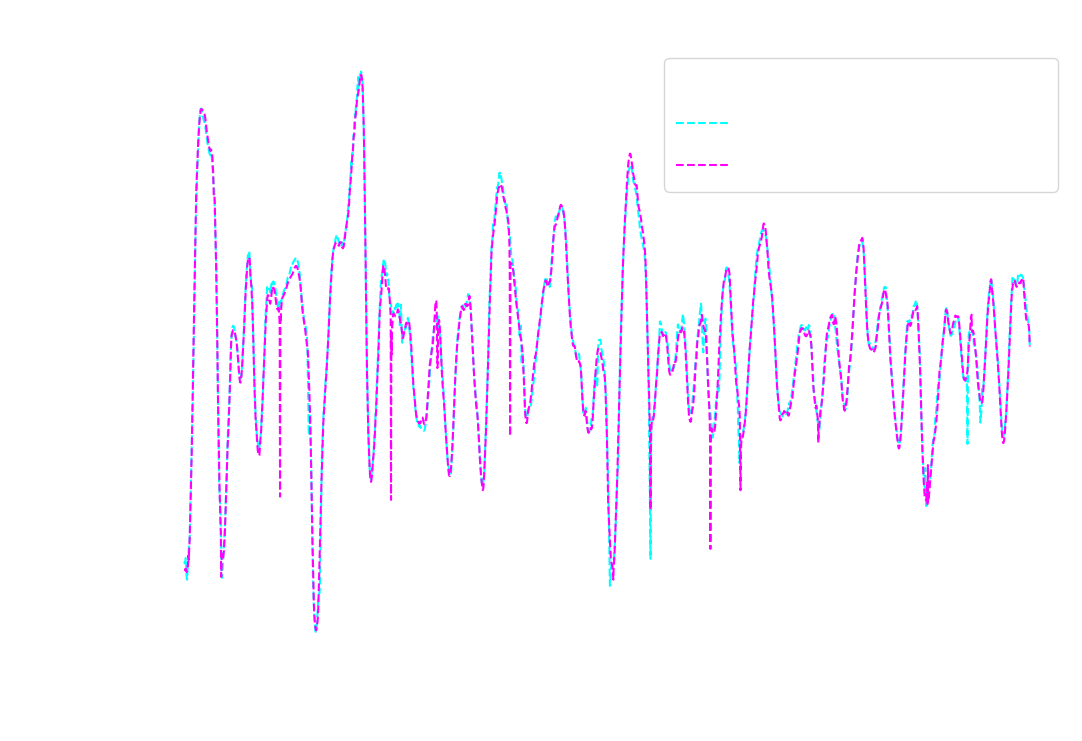

Loss:	Energy 		 MSE
MSE:	0.0114		 0.0657
MSE + Energy Kernel:	0.0105		 0.0583


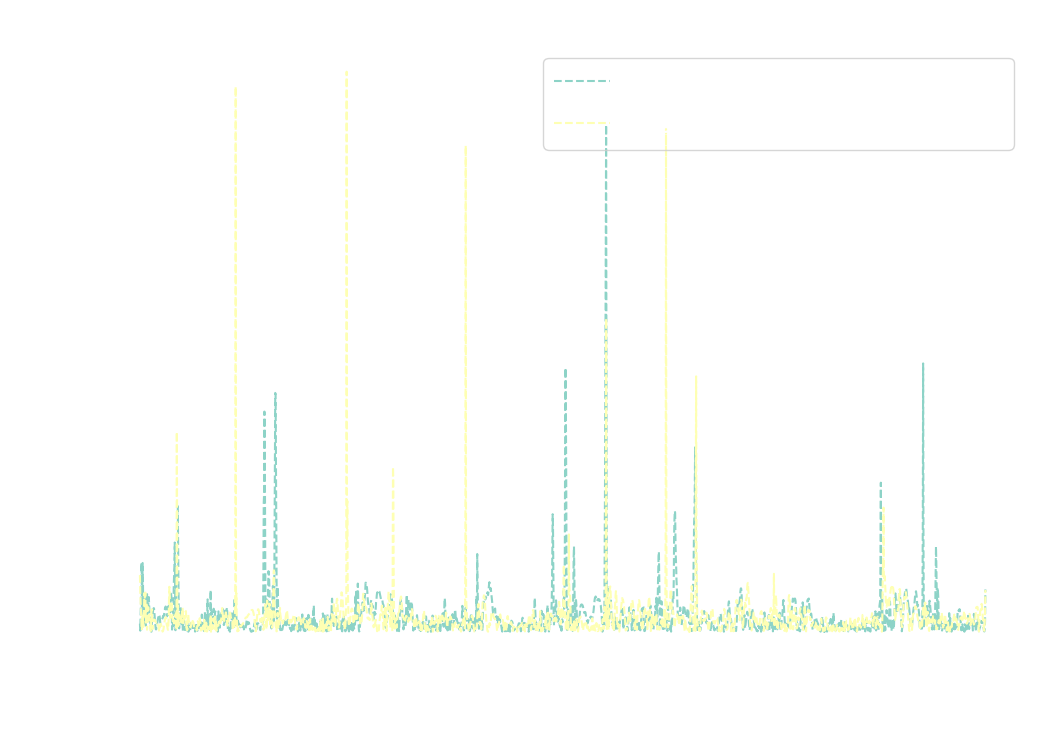

In [29]:

# Plot energy reconstruction
plt.figure(figsize=(12, 8))
plt.plot(energy_X_train[-2500:], 'w', label='Simulation')
colors = ['#00FFFF', '#FF00FF', '#FFFF00', '#00FF00', '#FFA500', '#FF0000', '#0000FF']
for k, e, c in zip(labels, energies, colors):
    plt.plot(e[-2500:], '--', label=k, color=c)
plt.legend()
plt.title('VAE Energy Reconstruction')
plt.xlabel('Snapshot Index')
plt.ylabel('Energy')
plt.show()

print(f'Loss:\tEnergy \t\t MSE')
for k, e, m in zip(labels, err_energy, mses):
    print(f'{k}:\t{e:.3g}\t\t {m:.3g}')

plt.figure(figsize=(12, 8))
for k, e in zip(labels, energies):
    error = np.abs(energy_X_train[-2500:] - e[-2500:]) / energy_X_train[-2500:]
    plt.plot(error, '--', label=f'{k} Error')

plt.legend()
plt.title('Energy Reconstruction Error')
plt.xlabel('Snapshot Index')
plt.ylabel('Relative Error')
plt.show()

In [92]:
len(X_train)

3000

In [138]:
# create a pointwise energy calculation based on the
# BEGIN: pointwise energy calculation based on the get_energy method
def get_energy(X, Wi, beta, Re, dx, dy):
    _, _, energy = calc_energy(X, Wi, beta, Re, dx, dy)
    return energy

pointwise_energy_train = get_energy(X_train.T, Wi, beta, Re, dx, dy)
pointwise_energy_test = get_energy(X_test.T, Wi, beta, Re, dx, dy)
# END: pointwise energy calculation based on the get_energy method

AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'

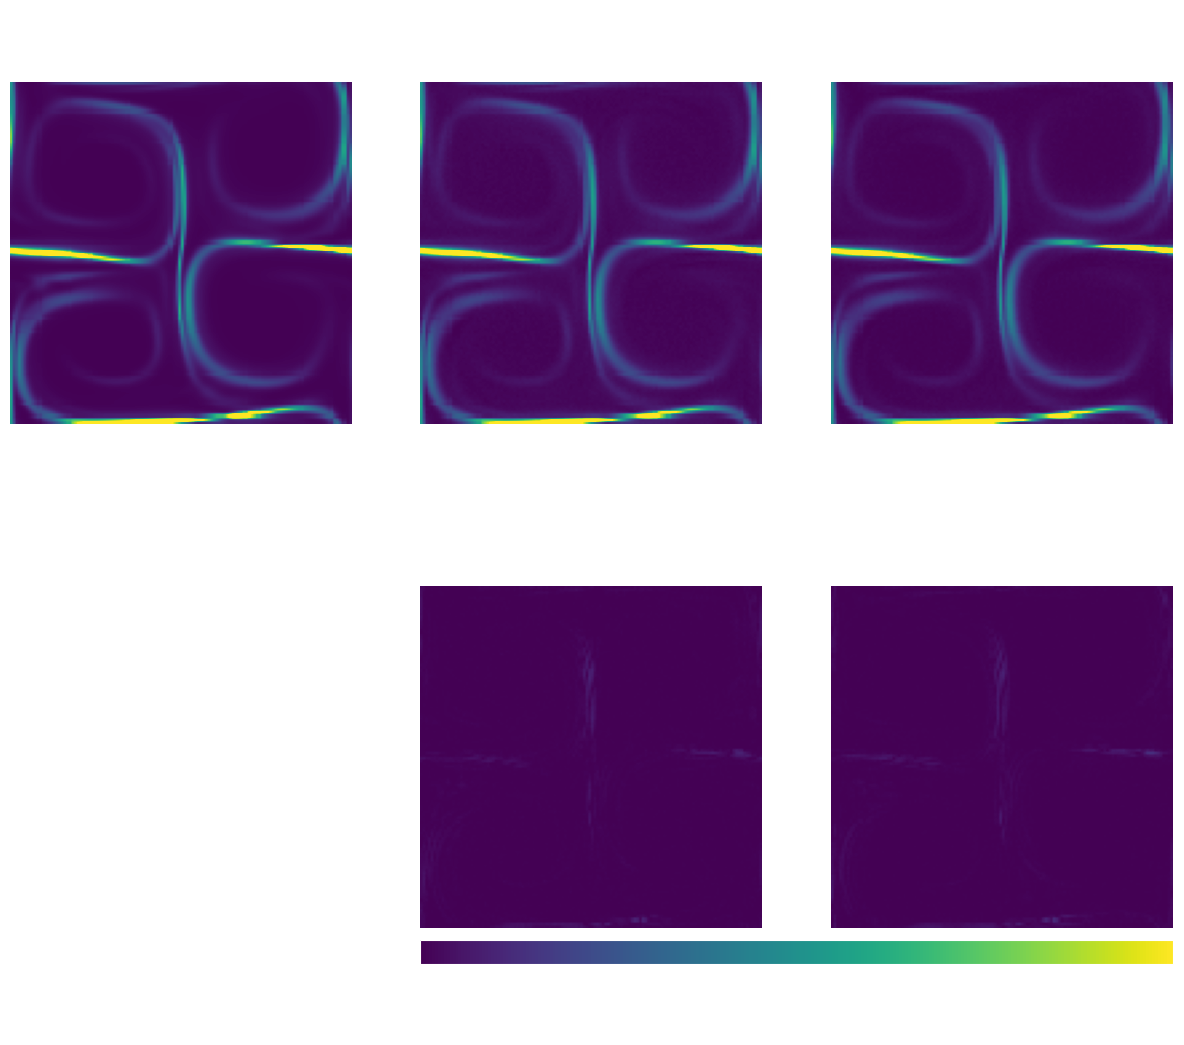

In [162]:
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


tra_x = get_tra(X_train.T).reshape(128, 128, -1)
tra_ae = []
tra_err = []
for x in X_rec_ae:
    tra_ae.append(get_tra(x).reshape(128, 128, -1))
    tra_err.append(np.abs(tra_x - get_tra(x).reshape(128, 128, -1)) / np.max(np.abs(tra_x)))

fig, axs = plt.subplots(2, 3, figsize=(15, 12))
axs[0, 0].set_axis_off()
axs[0, 1].set_axis_off()
axs[0, 2].set_axis_off()
axs[1, 0].set_axis_off()
axs[1, 1].set_axis_off()
axs[1, 2].set_axis_off()
# Initialize the plots
im0 = axs[0, 0].imshow(tra_x[..., 0], label='Simulation')
axs[0, 0].set_title('Simulation')

im1 = axs[0, 1].imshow(tra_ae[0][..., 0], label='Autoencoder\n(MSE Loss)')
axs[0, 1].set_title('Autoencoder\n(MSE Loss)')

im2 = axs[0, 2].imshow(tra_ae[1][..., 0], label='Autoencoder\n(MSE + Energy Loss)')
axs[0, 2].set_title('Autoencoder\n(MSE + Energy Loss)')

im3 = axs[1, 1].imshow(tra_err[0][..., 0], label='Absolute Error\n(MSE Loss)')
axs[1, 1].set_title('Absolute Error\n(MSE Loss)')

im4 = axs[1, 2].imshow(tra_err[1][..., 0], label='Absolute Error\n(MSE + Energy Loss)')
axs[1, 2].set_title('Absolute Error\n(MSE + Energy Loss)')

# Create a single horizontal colorbar for both plots
cax = fig.add_axes([axs[1, 1].get_position().x0, axs[1, 1].get_position().y0 - 0.03,
                    axs[1, 2].get_position().x1 - axs[1, 1].get_position().x0 , 0.02])
cbar = fig.colorbar(im3, cax=cax, orientation='horizontal')
cbar.ax.set_xlabel('Error')

# Adjust layout to reduce space between rows
# fig.tight_layout()
# plt.subplots_adjust(hspace=0.3)  # Adjust hspace to reduce space between rows
# Update colorbars

vmin = np.min([np.min(x) for x in tra_err])
vmax = np.max([np.max(x) for x in tra_err])
im3.set_clim(vmin=vmin, vmax=vmax)
im4.set_clim(vmin=vmin, vmax=vmax)
cbar.update_normal(im3)

def update_plot(frame):
    im0.set_data(tra_x[..., frame])
    im1.set_data(tra_ae[0][..., frame])
    im2.set_data(tra_ae[1][..., frame])
    im3.set_data(tra_err[0][..., frame])
    im4.set_data(tra_err[1][..., frame])
    

# ani = animation.FuncAnimation(fig, update_plot, frames=4, repeat=False)
ani = animation.FuncAnimation(fig, update_plot, frames=np.arange(0,tra_x.shape[-1],15), repeat=False)
ani.save('autoencoder_reconstruction_with_error_test.gif', writer='ffmpeg', fps=60)
plt.show()


In [40]:
kls = [ 1e-3, 10., 25., 50., 75., 100., 150., 200.]
latent_dim = 20
dkls = []
case = 'BOTH'
ae = Autoencoder.VariationalAutoencoderModule(X_train_torch.shape[-1], latent_dim, max_in, min_in).to(device)
energies = []
mses = []
err_energy = []
norm_mse = np.linalg.norm(X_train)
sum_energy = energy_X_train.sum()
X_rec_ae = []
for kl in kls:
    print(f'KL: {kl}')
    ae.load_state_dict(torch.load(f'../ModelsTorch/VAE_Latent_{latent_dim}_energy_{case}_kl_{kl}_{simulation_name}/best_autoencoder',map_location=device, weights_only=True))
    ae.eval()

    X_rec,mu,logvar = ae(X_train_torch.to(device))
    dkl = -0.5 * torch.mean(1 + logvar - mu ** 2 - logvar.exp(), dim = 0)

    dkl_sorted, dkl_indices = torch.sort(dkl, descending=True)
    dkls.append(dkl_sorted.cpu().detach().numpy())


    X_rec = torch2np(X_rec)
    X_rec_ae.append(X_rec)

    # 4- Calc error
    _, _, energy_rec = calc_energy(X_rec,Wi,beta, Re, dx, dy)
    energies.append(energy_rec)
    mses.append(np.linalg.norm(X_train - X_rec.T) / norm_mse)
    err_energy.append(np.abs(energy_X_train - energy_rec).sum()/ sum_energy)

# # KPCA


KL: 0.001
KL: 10.0
KL: 25.0
KL: 50.0
KL: 75.0
KL: 100.0
KL: 150.0
KL: 200.0


beta:	Energy 		 MSE
0.001:	0.0124		 0.0512
10.0:	0.0264		 0.0726
25.0:	0.0334		 0.1
50.0:	0.0354		 0.11
75.0:	0.0366		 0.106
100.0:	0.0315		 0.0982
150.0:	0.0425		 0.142
200.0:	0.0436		 0.135


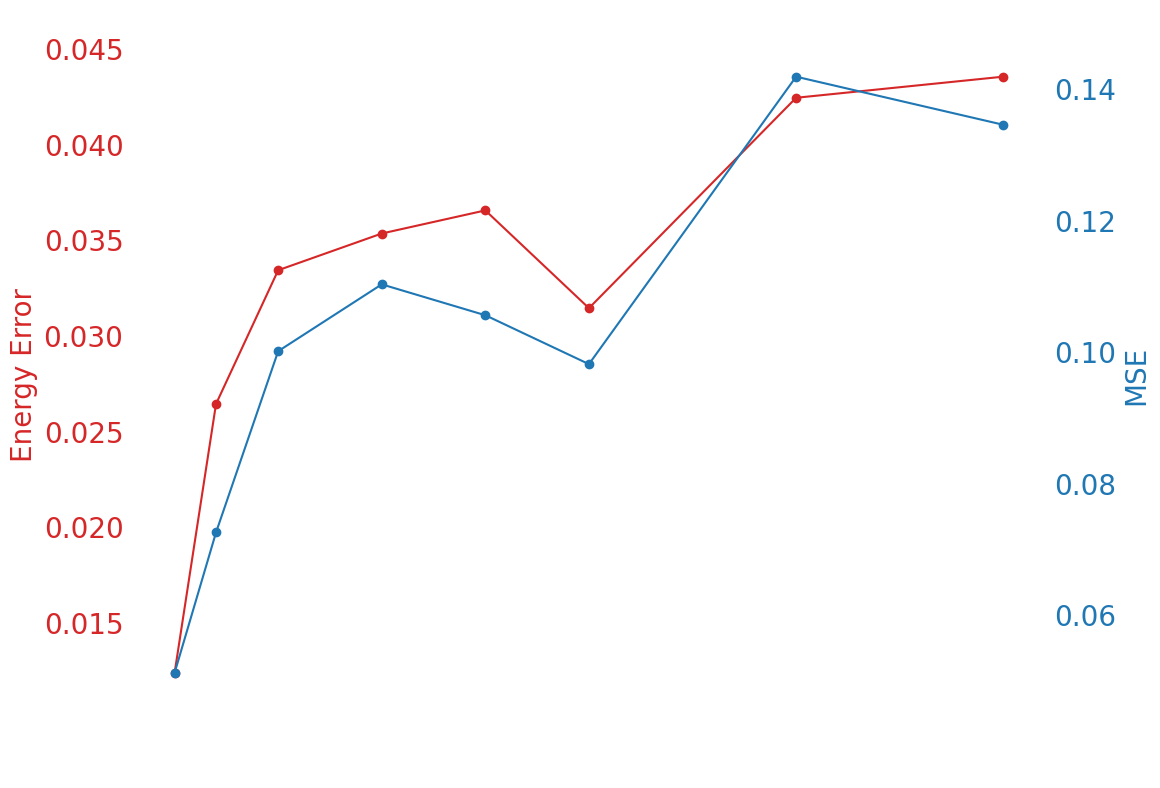

In [52]:

# Plot energy reconstruction
# plt.figure(figsize=(12, 8))
# plt.plot(energy_X_train[-2500:], 'w', label='Simulation')
# colors = ['#00FFFF', '#FF00FF', '#FFFF00', '#00FF00', '#FFA500', '#FF0000', '#0000FF']
# for k, e, c in zip(kls, energies, colors):
#     plt.plot(e[-2500:], '--', label=k, color=c)
# plt.legend()
# plt.title('Energy Reconstruction')
# plt.xlabel('Snapshot Index')
# plt.ylabel('Energy')
# plt.show()

print(f'beta:\tEnergy \t\t MSE')
for k, e, m in zip(kls, err_energy, mses):
    print(f'{k}:\t{e:.3g}\t\t {m:.3g}')

# plt.figure(figsize=(12, 8))
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('$\\beta_{KL}$')
ax1.set_ylabel('Energy Error', color=color)
ax1.plot(kls, err_energy, 'o-', color=color, label='Energy Error')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(kls)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('MSE', color=color)
ax2.plot(kls, mses, 'o-', color=color, label='MSE')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Energy Error and MSE vs $\\beta_{KL}$')
plt.show()

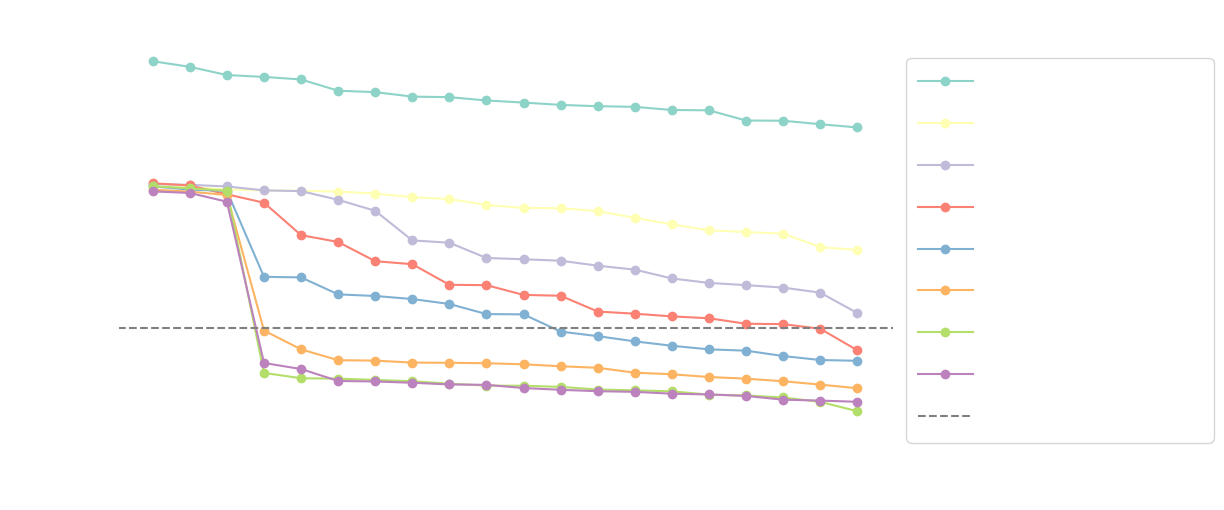

In [48]:

plt.figure(figsize=(10, 5))
for dkl,kl in zip(dkls, kls):
    plt.plot(dkl, 'o-', label=f'KL={kl}')
threshold = 1e-2
plt.axhline(threshold, color='gray', linestyle='--', label=f'Threshold {threshold:g}', alpha =1)
plt.yscale('log')
plt.xlabel('Latent Dimensions')
plt.ylabel('DKL')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.legend()
plt.title(f'Sorted DKL for different training KL values')
plt.xticks(ticks=np.arange(0,len(dkl_sorted),2), labels=np.arange(0,len(dkl_sorted),2))
plt.show()

In [12]:
1/0.08

12.5

DKL MSE: tensor([  9.7894,   7.2870,  51.5983,  29.5532,  18.7045,   7.7243,  20.5355,
         75.7514, 130.7541,   9.5995,  36.3495,  56.5673,   4.9508,  51.5875,
         12.2890,   6.6543,  19.2191,  57.3840,  81.6886, 126.8814],
       device='cuda:0')
DKL BOTH: tensor([15.0095, 26.7406,  6.5750, 85.9829, 26.7874, 16.0620, 10.4666, 34.0748,
         8.3327,  6.1880, 12.2240,  5.3256,  5.7923,  7.7632,  9.3253,  8.2164,
        72.5480,  9.7873,  5.9354, 35.7498], device='cuda:0')


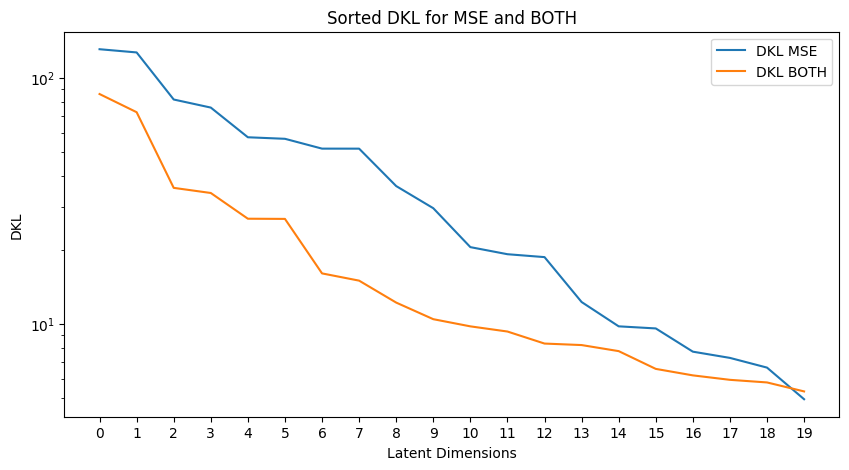

In [19]:


def compute_dkl(ae, X_test_torch):
    with torch.no_grad():
        X_rec, mu, logvar = ae(X_test_torch.to(device))
        dkl = -0.5 * torch.mean(1 + logvar - mu ** 2 - logvar.exp(), dim = 0)
    return dkl

dkl_mse = compute_dkl(ae_mse, X_test_torch)
dkl_both = compute_dkl(ae_both, X_test_torch)
dkl_mse_sorted, dkl_mse_indices = torch.sort(dkl_mse, descending=True)
dkl_both_sorted, dkl_both_indices = torch.sort(dkl_both, descending=True)
print(f'DKL MSE: {dkl_mse}')
print(f'DKL BOTH: {dkl_both}')


plt.figure(figsize=(10, 5))
plt.plot(dkl_mse_sorted.cpu().numpy(), label='DKL MSE')
plt.plot(dkl_both_sorted.cpu().numpy(), label='DKL BOTH')
plt.yscale('log')
plt.xlabel('Latent Dimensions')
plt.ylabel('DKL')
plt.legend()
plt.title('Sorted DKL for MSE and BOTH')
plt.xticks(ticks=np.arange(len(dkl_mse_sorted)), labels=np.arange(len(dkl_mse_sorted)))
plt.show()

In [4]:
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'



In [20]:
import numpy as np
from KPCA import KernelPCA
from utils import calc_energy, np2torch, torch2np

import matplotlib.pyplot as plt

# Assuming X_train, Wi, beta, Re, dx, dy, and theta are already defined in the notebook

components = range(2, 21)
energy_errors = []

kpca = KernelPCA()
kpca.fit(X_train, 20, kernel='oldroyd', eps=None, theta=theta[0, 0])


In [7]:

for n_components in components:
    kpca.train_R(n_components=n_components)
    
    phi = kpca.transform(X_train, theta=theta[0, 0], eps=None)
    X_rec = kpca.invert_transform(phi, theta[0, 0])
    
    _, _, energy_rec = calc_energy(X_rec, Wi, beta, Re, dx, dy)
    energy_error = np.abs(energy_X_train - energy_rec).sum() / energy_X_train.sum()
    energy_errors.append(energy_error)



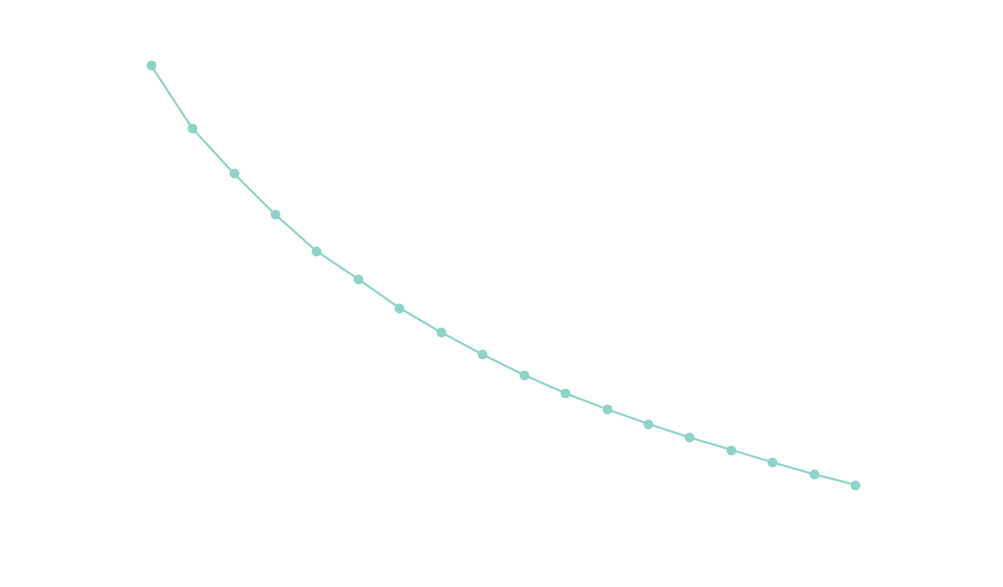

In [8]:


fig = plt.figure(figsize=(10, 6))
fig.patch.set_alpha(0.0)
plt.plot(components[1:], energy_errors[1:], marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Energy Error')
plt.title('Energy Error vs Number of Components for Oldroyd Kernel')
plt.xticks(range(3, 21))
# plt.grid(True)
plt.show()


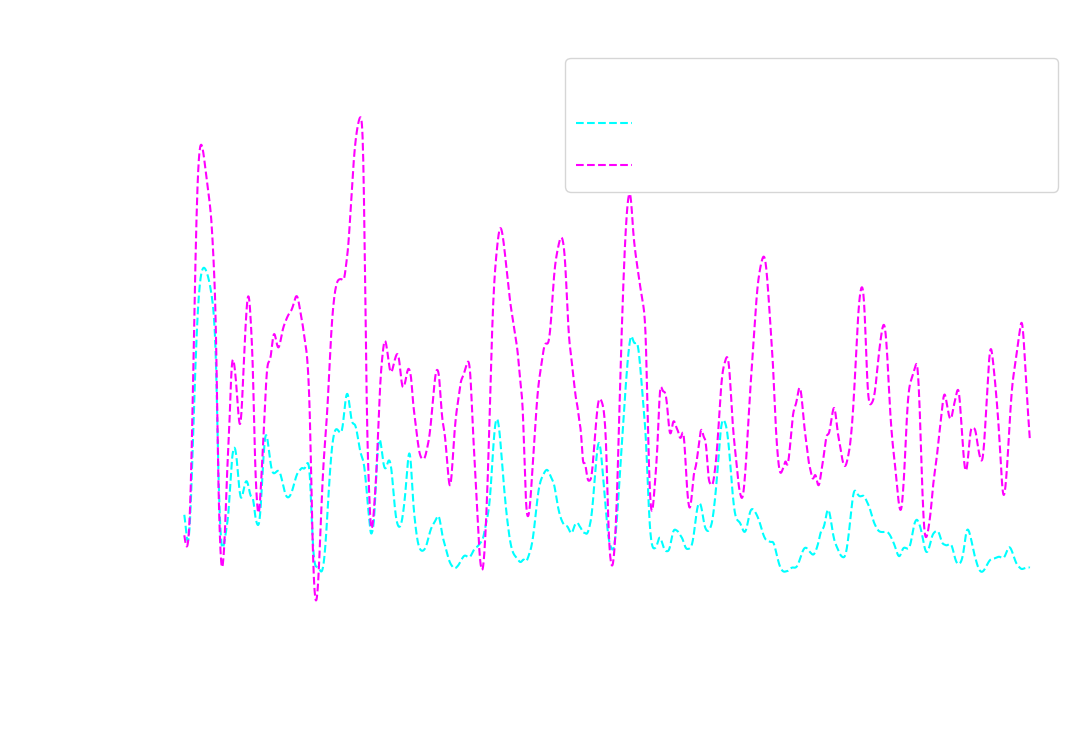

In [22]:
plt.rcParams.update({'font.size': 20})
components_to_plot = [3, 20]
plt.figure(figsize=(12, 8))
colors = ['#00FFFF', '#FF00FF', '#FFFF00', '#00FF00', '#FFA500', '#FF0000', '#0000FF']

plt.plot(energy_X_train[-2500:],'w', label=f'True Energy')
for i,n_components in enumerate(components_to_plot):
    kpca.train_R(n_components=n_components)
    phi = kpca.transform(X_train, theta=theta[0, 0], eps=None)
    X_rec = kpca.invert_transform(phi, theta[0, 0])
    
    _, _, energy_rec = calc_energy(X_rec, Wi, beta, Re, dx, dy)
    
    plt.plot(energy_rec[-2500:], '--', label=f'Reconst. Energy ({n_components} modes)', c=colors[i])
    plt.xlabel('Snapshot Index')
    plt.ylabel('Energy')
    plt.title(f'KPCA Reconstruction')
    plt.legend()
    # plt.grid(True)
plt.show()

In [18]:
plt.show()

In [ ]:
# Anotação para criação da apresentação

# 1. Apresentação do problema fluidos viscoelásticos
# - Introdução aos fluidos viscoelásticos
# - Importância do estudo desses fluidos
# - Desafios na simulação e análise de fluidos viscoelásticos

# 2. Apresentação do KPCA com kernel energia
# - Introdução ao Kernel Principal Component Analysis (KPCA)
# - Explicação do kernel de energia utilizado
# - Vantagens do uso do KPCA com kernel de energia para análise de fluidos viscoelásticos

# 3. Apresentação da limitação para turbulência
# - Discussão sobre as limitações do KPCA em cenários de turbulência
# - Exemplos de casos onde o KPCA não é eficaz
# - Necessidade de métodos mais avançados para lidar com turbulência

# 4. Apresentação do Variational Autoencoder (VAE)
# - Introdução ao conceito de Variational Autoencoder
# - Estrutura e funcionamento do VAE
# - Aplicação do VAE na análise de fluidos viscoelásticos

# 5. Mostrar influência do DKL
# - Explicação sobre a divergência Kullback-Leibler (DKL)
# - Importância do DKL na otimização do VAE
# - Resultados mostrando a influência do DKL no desempenho do VAE

# 6. Mostrar comparação com VAE clássico
# - Comparação entre o VAE clássico e o VAE com kernel de energia
# - Resultados experimentais e gráficos comparativos
# - Discussão sobre as vantagens e desvantagens de cada abordagem

# Fim da anotação

In [ ]:
def objective(trial):
        # 2 - Apply KPCA
        kpca = KPCA.KernelPCA()
        gamma = trial.suggest_float("sigma", 1e-3, 1e3, log=True)
        kpca.fit(X,2, kernel='rbf',eps = gamma, theta=theta)

        # 3 - Create Reconstruction
        phi = kpca.transform(X, theta = theta, eps = gamma)
        X_rec = kpca.invert_transform(phi, theta)

        # 4- Calc energy
        _, _, energy_rec = calc_energy(X_rec, Wi, beta, Re, dx, dy)

        # 5- Calc error
        err = np.sum(np.abs(energy_X - energy_rec)) / np.sum(np.abs(energy_X))
        return err
    study  = optuna.create_study()
    study.optimize(objective, n_trials=200)

    thetas.append(theta)
    studies.append(study)
    best_sigma.append(study.best_trial.params['sigma'])